In [81]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import gymnasium as gym

In [82]:
class DQN(torch.nn.Module):
    def __init__(self, n_states,n_actions,n_hidden_units):
        super(DQN, self).__init__()
        self.state_dim = n_states
        self.num_hidden_units = n_hidden_units
        
        self.num_actions = n_actions
        self.layer1 = torch.nn.Linear(self.state_dim, self.num_hidden_units)
        self.layer2 = torch.nn.Linear(self.num_hidden_units,self.num_hidden_units)
        self.layer3 = torch.nn.Linear(self.num_hidden_units, self.num_actions)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.layer_norm = torch.nn.LayerNorm(self.num_hidden_units)
        self.relu = torch.nn.ReLU()

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.layer1(x)
        #x = self.dropout(x)
        #x = self.layer_norm(x)
        x = self.relu(x)
        x = self.layer2(x)
        #x = self.dropout(x)
        #x = self.layer_norm(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [83]:
class ReplayBuffer:
    def __init__(self, buffer_size, minibatch_size, observation_size):
        self.buffer = []
        self.minibatch_size = minibatch_size
        #random.seed(seed)
        self.max_size = buffer_size
        self.pos = 0
        self.full = False
        self.states = np.zeros((self.max_size,observation_size))
        self.next_states = np.zeros((self.max_size,observation_size))
        self.actions = np.zeros(self.max_size,dtype=np.int8)
        self.rewards = np.zeros(self.max_size)
        self.terminals = np.zeros(self.max_size,dtype=np.int8)
        self.rand_generator = np.random.RandomState()

    def set_seed(self,seed=1):
        self.rand_generator = np.random.RandomState(seed)


    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        self.states[self.pos] = state
        self.actions[self.pos] = action
        self.rewards[self.pos] = reward
        self.terminals[self.pos] = terminal
        self.next_states[self.pos] = next_state
        self.pos += 1
        if(self.pos==self.max_size):
            self.pos = 0
            self.full = True


    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        if(self.full):
            idxs = self.rand_generator.randint(0,self.max_size,size=self.minibatch_size) 
        else:
            idxs = self.rand_generator.randint(0,self.pos,size=self.minibatch_size)
        sample_ = [self.states[idxs],self.actions[idxs],self.rewards[idxs],self.terminals[idxs],
                   self.next_states[idxs]]
        #print(sample_)
        return sample_

    def size(self):
        if(self.full):
            return self.max_size
        else:
            return self.pos
    
    def reset(self):
        self.full = False
        self.pos = 0

In [84]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, target_network, current_q_network):
    with torch.no_grad():
        # The idea of Double DQN is to get max actions from current network
        # and to get Q values from target_network for next states. 
        q_next_mat = current_q_network(next_states)
        max_actions = torch.argmax(q_next_mat,1)
        double_q_mat = target_network(next_states)
    batch_indices = torch.arange(q_next_mat.shape[0])
    double_q_max = double_q_mat[batch_indices,max_actions]
    target_vec = rewards+discount*double_q_max*(torch.ones_like(terminals)-terminals)
    q_mat = current_q_network(states)
    batch_indices = torch.arange(q_mat.shape[0])
    q_vec = q_mat[batch_indices,actions]
    #delta_vec = target_vec - q_vec
    return target_vec,q_vec

In [85]:
def optimize_network(experiences, discount, optimizer, target_network, current_q_network,device):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions,
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets,
                                        and particularly, the action-values at the next-states.
    """
    # Get states, action, rewards, terminals, and next_states from experiences
    states = experiences[0]
    actions = experiences[1]
    rewards = experiences[2]
    terminals = experiences[3]
    next_states = experiences[4]
    # numpy arrays to tensors and move to device (cpu or gpu)
    states = torch.tensor(states,dtype=torch.float32,device=device)
    next_states = torch.tensor(next_states,dtype=torch.float32,device=device)
    rewards = torch.tensor(rewards,dtype=torch.float32,device=device)
    terminals = torch.tensor(terminals,dtype=torch.int,device=device)
    actions = torch.tensor(actions,dtype=torch.int,device=device)
 
    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    target_vec,q_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, target_network, current_q_network)
    loss_fun = torch.nn.MSELoss()
    loss = loss_fun(target_vec,q_vec)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(current_q_network.parameters(), 10)
    optimizer.step()
    return loss.detach().cpu().numpy()

In [86]:
class DQNAgent:
    def __init__(self,buffer_config):
        self.name = "DQN"
        self.device = None
        self.rand_generator = np.random.RandomState() # random seed. Later can be changed by using set_seed method
        self.replay_buffer = ReplayBuffer(buffer_config["replay_buffer_size"],
                                          buffer_config["minibatch_sz"],
                                          buffer_config["observation_size"])

    def set_seed(self,seed=1):
        self.rand_generator = np.random.RandomState(seed)
        #random.seed(self.seed)
    
    def set_epsilon_decay(self,n_steps=10000):
        self.eps_decay = 1. - 1./n_steps

    def set_device(self,device="cpu"):
        if(device=="cuda"):
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device("cpu")
    
    def agent_init(self, agent_config):
        if(self.device==None):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.state_dim = agent_config["network_config"].get("state_dim")
        self.num_hidden_layers = agent_config["network_config"].get("num_hidden_units")
        self.num_actions = agent_config["network_config"].get("num_actions")
        
        self.network_type = agent_config["network_config"].get("network_type")
        
        self.q_network = DQN(self.state_dim,self.num_actions,self.num_hidden_layers).to(self.device)
        self.target_network = DQN(self.state_dim,self.num_actions,self.num_hidden_layers).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.step_size = agent_config['step_size']
        self.double_dqn = agent_config['double_dqn']
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.epsilon = agent_config['epsilon']
        self.time_step = 0
        self.update_freq = agent_config['update_freq']
        self.loss = []
        self.episode_rewards = []
        self.loss_capacity = 5_000
        self.warmup_steps = agent_config['warmup_steps']
        self.eps_decay = 0.9999
        self.last_state = None
        self.last_action = None
        self.sum_rewards = 0
        self.episode_steps = 0
        self.optimizer = torch.optim.Adam(self.q_network.parameters(),lr=self.step_size,weight_decay=0.01)

    def greedy_policy(self,state,epsilon=0.001):
        state = torch.tensor(state,dtype=torch.float32,device=self.device)
        a = self.rand_generator.rand()
        if(a>=epsilon):
            with torch.no_grad():
                action_values = self.q_network(state)
            action = torch.argmax(action_values).item()
        else:
            action = self.rand_generator.choice(self.num_actions)
        return action

    def epsilon_greedy_policy(self,state):
        epsilon = np.max([self.epsilon,0.05]) 
        state = torch.tensor(state,dtype=torch.float32,requires_grad=False,device=self.device)
        self.epsilon *= self.eps_decay
        a = self.rand_generator.rand()
        if(a>=epsilon):
            with torch.no_grad():
                action_values = self.q_network(state)
            action = torch.argmax(action_values).item()
        else:
            action = self.rand_generator.choice(self.num_actions)
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = state #torch.tensor(np.array([state]),dtype=torch.float32,device=self.device)
        self.last_action = self.epsilon_greedy_policy(self.last_state)
        self.time_step += 1
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        #state = torch.tensor(np.array([state]),dtype=torch.float32,device=self.device)
        action = self.epsilon_greedy_policy(state)
        terminal = False
        self.replay_buffer.append(self.last_state, self.last_action, reward, terminal, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size and self.time_step>self.warmup_steps: # and self.episode_steps%self.replay_buffer.minibatch_size==0:
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                loss = optimize_network(experiences, self.discount, self.optimizer, self.target_network, self.q_network,self.device)
                if(len(self.loss)>=self.loss_capacity):
                    del self.loss[0]
                self.loss.append(loss)

        if(self.time_step%self.update_freq==0):
            #print("Updating network")
            self.update_target_network()
       
        self.last_state = None
        self.last_action = None

        ### END CODE HERE
        # your code here
        self.last_state = state
        self.last_action = action
        self.time_step += 1
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        self.episode_rewards.append(self.sum_rewards)
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state) #torch.zeros_like(self.last_state,device=self.device)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments
        end_loss = 0
        # your code here
        terminal = True
        self.replay_buffer.append(self.last_state, self.last_action, reward, terminal, state)
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                loss = optimize_network(experiences, self.discount, self.optimizer, self.target_network, self.q_network,self.device)
                end_loss = loss
                if(len(self.loss)>=self.loss_capacity):
                    del self.loss[0]
                self.loss.append(loss)
        
        if(self.time_step%self.update_freq==0):
            self.update_target_network()
        self.time_step += 1
    
        return end_loss

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_loss(self):
        return np.average(np.array(self.loss))

In [87]:
class RL:
    def __init__(self) -> None:
        self.name = "ButaChanRL"
        self.mean_episode_length = 0
        self.mean_episode_rew = 0
        self.mean_loss= 0
        self.step = 0
        self.output_step = 1000
        self.epsiode_rewards = []
        self.episode_lens = []
        self.loss = []
        
        self.model_dir = "./models/"
        self.num_episodes = 0
        self.average_over = 20

    def set_output_step(self,output_step):
        self.output_step = output_step

    def set_model_dir(self,name):
        self.model_dir = name

    def create_model_dir(self):
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

    def load_model(self,model,filename="model.weights"):
        if(model.name == "DQN"):
            model.target_network.load_state_dict(torch.load(filename))
            model.q_network.load_state_dict(torch.load(filename))
        elif(model.name=="ActorCritic"):
            model.actor_critic_network.load_state_dict(torch.load(filename))
        else:
            NotImplementedError()


    def save_model(self,model,filename="model.weights"):
        if(model.name == "DQN"):
            torch.save(model.q_network.state_dict(),filename)
        elif(model.name=="ActorCritic"):
            torch.save(model.actor_critic_network.state_dict(),filename)

     
    def plot_live(self,data,n_mean=20,plot_start=20):
        plt.ion()
        plt.figure(1)
        plot_data = torch.tensor(data, dtype=torch.float)
        plt.clf()
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.plot(plot_data.numpy(),"o")
        # Take 100 episode averages and plot them too
        if len(plot_data ) >= plot_start:
            means = plot_data .unfold(0, n_mean, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(n_mean), means))
            plt.plot(means.numpy())
        plt.pause(0.1)  # pause a bit so that plots are updated


    def episode_summarize(self,episode,episode_reward):
        print(f"Episode: {episode}, Reward: {episode_reward}")

    def summarize(self):
        self.mean_episode_length = 0
        self.mean_episode_rew = 0
        if(len(self.episode_lens)>0):
            if(len(self.episode_lens)>self.average_over):
                self.mean_episode_length = np.average(self.episode_lens[-self.average_over:-1])
                self.mean_episode_rew = np.average(self.epsiode_rewards[-self.average_over:-1])
            else:
                self.mean_episode_length = np.average(self.episode_lens)
                self.mean_episode_rew = np.average(self.epsiode_rewards)
        self.mean_loss = 0
        if(len(self.loss)>0):
            self.mean_loss = np.average(self.loss)
        print(f"Step:{self.step}, Episode:{self.num_episodes} Mean_Epi_Len: {self.mean_episode_length:5.2f},Mean_Epi_Rew {self.mean_episode_rew:5.2f}, Loss: {self.mean_loss:5.2f}")

    def learn(self,agent,env,agent_parameters,NSTEPS=10000,visualize=False,save_best_weights=False,offline=False):
        epsiode = 1
        
        
        # prepare agent
        agent.agent_init(agent_parameters)
        if(offline):
            agent.load_buffer("experienceReplay.json")
        #agent.set_epsilon_decay(NSTEPS//2)
        state,info= env.reset() 
        state = torch.tensor(state,dtype=torch.float32)
        #state = torch.unsqueeze(state,0)
        # choose initial action based on agent's results
        action = agent.agent_start(state)
        done = False
        epsiode_reward = 0
        episode_len = 0
        
        for i in tqdm(range(1,NSTEPS+1)):
            self.step = i
            #print(action)
            state,reward,terminated,truncated,info=env.step(action)
            state = torch.tensor(state,dtype=torch.float32)
            #state = torch.unsqueeze(state,0)
            #print(i,state,reward,action,done)
            epsiode_reward += reward
            done = terminated or truncated
            if(self.step%self.output_step==0):
                self.summarize()
                #print(f"Epsilon {agent.epsilon:>5.3f}")
                if(visualize):
                    if(len(self.epsiode_rewards)>0):
                        self.plot_live(self.epsiode_rewards)
            if(done):
                loss = agent.agent_end(reward)
                #print("Loss length",len(agent.loss))
                self.loss.append(loss)
                
                if(save_best_weights):
                    self.create_model_dir()
                    if(len(self.epsiode_rewards)==0):
                        model_name = self.model_dir+f"model_{self.step}"
                        self.save_model(agent,model_name)
                    else:
                        if(epsiode_reward>max(self.epsiode_rewards)):
                            model_name = self.model_dir+f"model_{self.step}"
                            self.save_model(agent,model_name)
                self.epsiode_rewards.append(epsiode_reward)
                self.episode_lens.append(episode_len)
                epsiode += 1
                self.num_episodes += 1
                # restart next episode
                state,_= env.reset() 
                state = torch.tensor(state,dtype=torch.float32)
                #state = torch.unsqueeze(state,0)
                action = agent.agent_start(state)
                done = False
                epsiode_reward = 0
                episode_len = 0
            else:
                action = agent.agent_step(reward,state)
                episode_len+=1
        return agent
    

    def evaluate(self,agent,env,n_episodes=10,seed=1,visualize=False,eval_espilon=0.001):
        epsiode_rewards = []
        for episode in range(1,n_episodes+1):
            state,info = env.reset()
            state = torch.tensor(state,dtype=torch.float32)
            state = torch.unsqueeze(state,0)
            #action = agent.greedy_policy(state,eval_espilon)
            action = agent.epsilon_greedy_policy(state)
            done = False
            epsiode_reward = 0
            episode_len = 0
            while not done:
                state,reward,terminated,truncated,info=env.step(action)
                state = torch.tensor(state,dtype=torch.float32)
                state = torch.unsqueeze(state,0)
                epsiode_reward += reward
                done = terminated or truncated
                #action = agent.greedy_policy(state,eval_espilon)
                action = agent.epsilon_greedy_policy(state)
                episode_len += 1
            epsiode_rewards.append(epsiode_reward)
            self.episode_summarize(episode,epsiode_reward)
            #if(visualize):
            #    env.summarize()
        mean_rew = np.average(epsiode_rewards)
        std_rew = np.std(epsiode_rewards)
        return (mean_rew,std_rew) 

C:\Users\Ridwa\AppData\Local\Temp\ipykernel_15980\2136567144.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state,dtype=torch.float32,requires_grad=False,device=self.device)
 10%|▉         | 963/10000 [00:00<00:01, 4746.27it/s]

Step:1000, Episode:44 Mean_Epi_Len: 21.68,Mean_Epi_Rew 22.68, Loss:  0.97


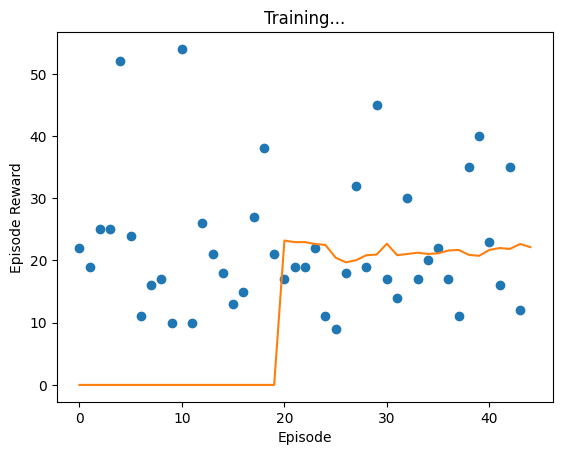

 19%|█▉        | 1907/10000 [00:02<00:11, 694.35it/s]

Step:2000, Episode:89 Mean_Epi_Len: 25.68,Mean_Epi_Rew 26.68, Loss:  0.88


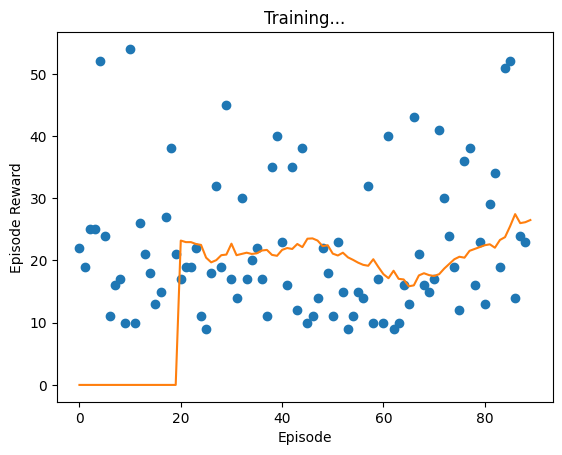

 30%|██▉       | 2998/10000 [00:04<00:19, 363.65it/s]

Step:3000, Episode:117 Mean_Epi_Len: 31.26,Mean_Epi_Rew 32.26, Loss:  1.30


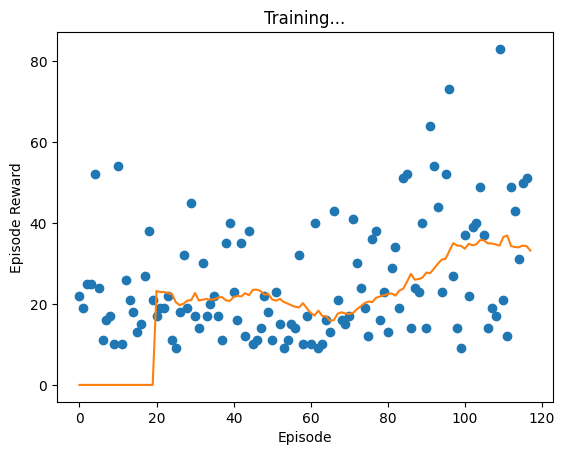

 40%|███▉      | 3969/10000 [00:08<00:20, 299.65it/s]

Step:4000, Episode:138 Mean_Epi_Len: 47.37,Mean_Epi_Rew 48.37, Loss:  2.08


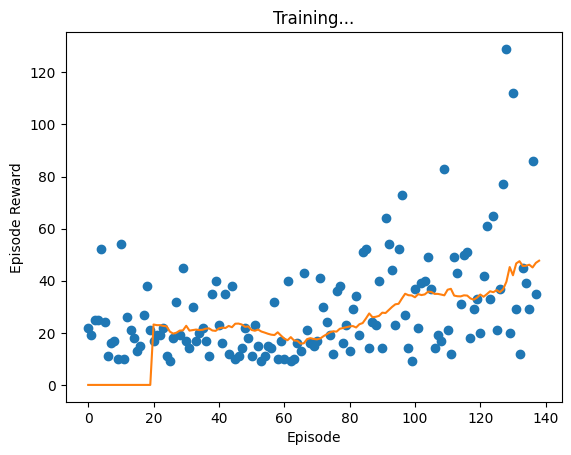

 50%|████▉     | 4982/10000 [00:11<00:16, 302.74it/s]

Step:5000, Episode:154 Mean_Epi_Len: 54.21,Mean_Epi_Rew 55.21, Loss:  2.79


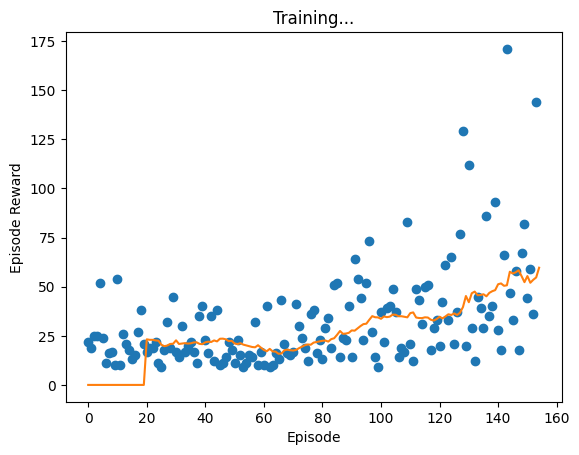

 60%|█████▉    | 5994/10000 [00:15<00:16, 246.16it/s]

Step:6000, Episode:168 Mean_Epi_Len: 71.26,Mean_Epi_Rew 72.26, Loss:  3.80


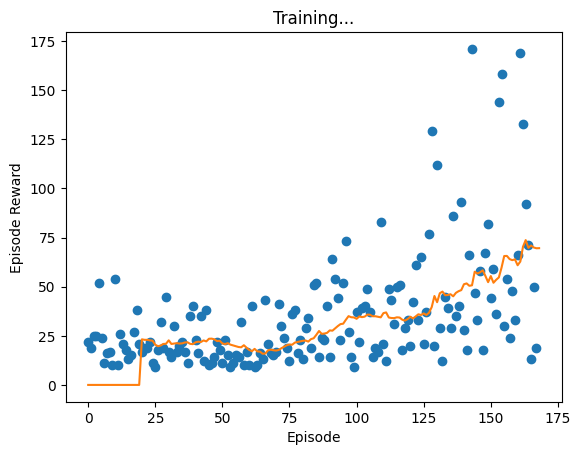

 70%|██████▉   | 6976/10000 [00:19<00:12, 247.68it/s]

Step:7000, Episode:175 Mean_Epi_Len: 86.42,Mean_Epi_Rew 87.42, Loss:  4.27


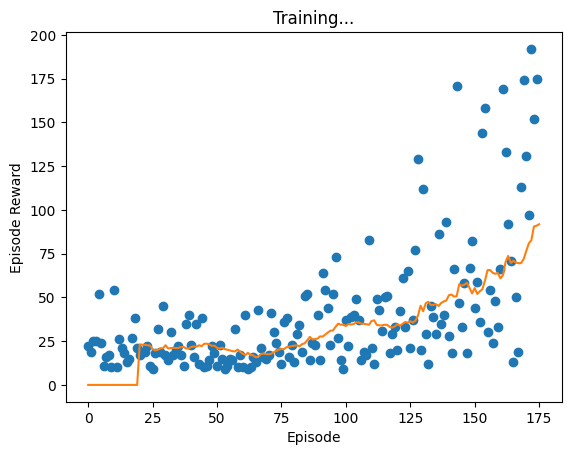

 80%|███████▉  | 7996/10000 [00:24<00:07, 264.94it/s]

Step:8000, Episode:183 Mean_Epi_Len: 112.89,Mean_Epi_Rew 113.89, Loss:  5.97


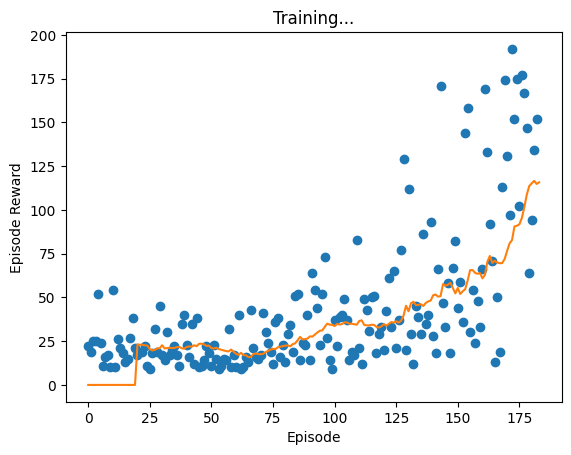

 90%|████████▉ | 8986/10000 [00:28<00:03, 302.06it/s]

Step:9000, Episode:188 Mean_Epi_Len: 138.53,Mean_Epi_Rew 139.53, Loss:  6.20


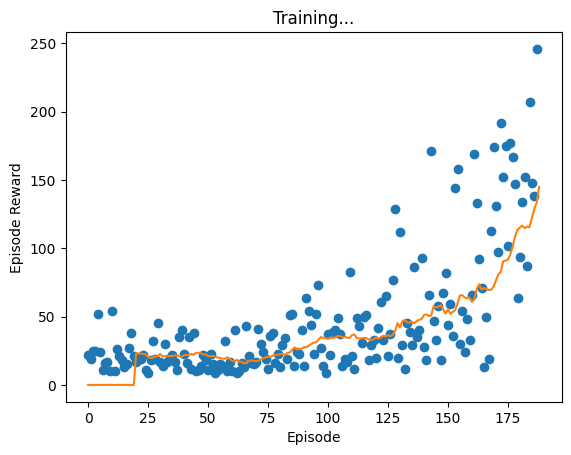

100%|█████████▉| 9984/10000 [00:31<00:00, 459.78it/s]

Step:10000, Episode:194 Mean_Epi_Len: 155.74,Mean_Epi_Rew 156.74, Loss:  6.94


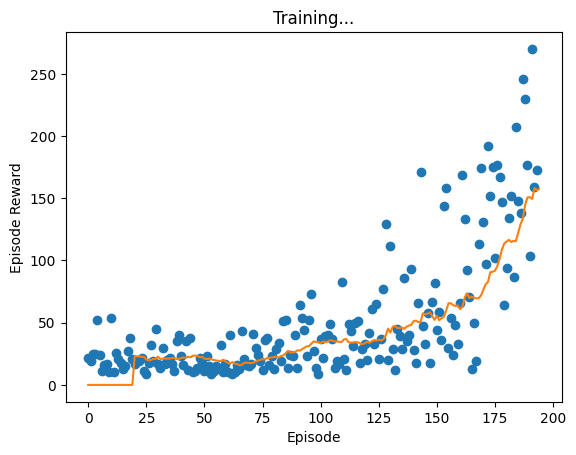

100%|██████████| 10000/10000 [00:31<00:00, 317.08it/s]


In [88]:
env = gym.make("CartPole-v1") # just create gym environment natively
torch.set_num_threads(1)  
n_state = env.observation_space.shape[0]
n_actions = env.action_space.n

agent_parameters = { # this is where you can choose neural networks adjust hyperparameters 
'network_config': {
    'state_dim': n_state,
    'num_hidden_units': 128,
    'num_actions': n_actions,
    "network_type":"dqn"
},
'replay_buffer_size': 1_000_000,
'minibatch_sz': 32,
'observation_size':n_state,
'num_replay_updates_per_step': 4,
"step_size": 3e-4,
'gamma': 0.99,
'epsilon': 1,
'update_freq':100,
'warmup_steps':1000,
'double_dqn':False
}
buffer_parameters = {
    "replay_buffer_size":1_000_000,
    "minibatch_sz":32,
    "observation_size":n_state
}
agent = DQNAgent(buffer_parameters) # You can change to other agents such as SARSA, ActorCritic

agent.set_device(device="cpu")
rl = RL() # You need this to control the overall process of training
s,_=env.reset(seed=1)
agent.set_seed(1)
agent.replay_buffer.set_seed(1)
trained_agent = rl.learn(agent,env,agent_parameters,NSTEPS=10_000,visualize=True,save_best_weights=False) # training loop
